In [221]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## About Dataset
This is text document classification dataset which contains 2225 text data and five categories of documents. Five categories are politics, sport, tech, entertainment and business. We can use this dataset for documents classification and document clustering.

> **Labels**
> * Politics = 0
> * Sport = 1
> * Technology = 2
> * Entertainment =3
> * Business = 4

### İmport Library

In [222]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import re
import string
import nltk
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords
nltk.download("stopwords")
from pymystem3 import Mystem
from nltk.util import ngrams
import snowballstemmer
from rutermextract import TermExtractor
from imblearn.under_sampling import RandomUnderSampler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /Users/a12/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [223]:
np.random.seed(42)
torch.manual_seed(42)

df = pd.read_csv("data_kaggle_ru.csv")
df.head()

,Unnamed: 0,text,label,data_source,url_data_source
0,0,Бюджет для создания условий для выборов\n \n Г...,0,KAGGLE_DATASET,https://www.kaggle.com/datasets/sunilthite/tex...
1,1,Армейские вожди в составе полков\n \n Ожидаетс...,0,KAGGLE_DATASET,https://www.kaggle.com/datasets/sunilthite/tex...
2,2,Говард отрицает разбивку на удостоверения личн...,0,KAGGLE_DATASET,https://www.kaggle.com/datasets/sunilthite/tex...
3,3,Наблюдатели за выборами в Соединенном Королевс...,0,KAGGLE_DATASET,https://www.kaggle.com/datasets/sunilthite/tex...
4,4,Килрой назвал выборное место\n \n Бывший орган...,0,KAGGLE_DATASET,https://www.kaggle.com/datasets/sunilthite/tex...


In [224]:

df = df[["text", "label"]]
df = df.rename(columns={'text':'Text','label':'Label'})

In [225]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    2225 non-null   object
 1   Label   2225 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 34.9+ KB


In [226]:
df.isnull().sum()

Text     0
Label    0
dtype: int64

In [227]:
df.duplicated().sum()

100

In [228]:
# we have to delete the repeated lines
df = df.drop_duplicates()
df.shape

(2125, 2)

Label
0    403
1    505
2    345
3    369
4    503
Name: count, dtype: int64


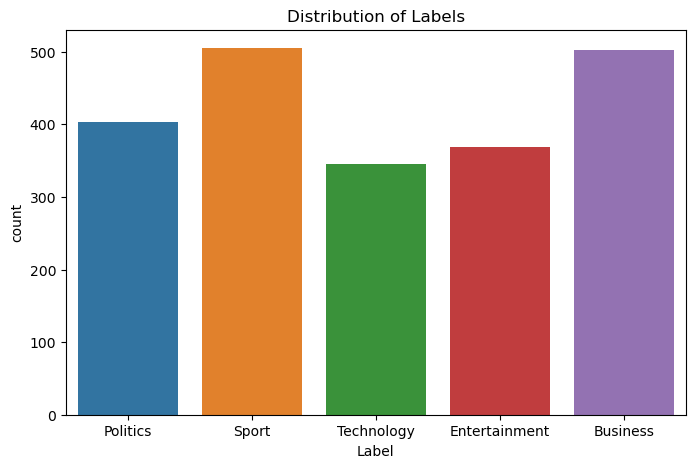

In [229]:
print(df.Label.value_counts().sort_index())
fig, ax=plt.subplots(figsize=(8,5))
sns.barplot(x=df.Label.value_counts().index, y=df.Label.value_counts(), ax=ax)
ax.set_title("Distribution of Labels")
ax.set_xticklabels(["Politics", "Sport", "Technology", "Entertainment", "Business"])
plt.show()

In [230]:
# sample text
df.Text[0]

'Бюджет для создания условий для выборов\n \n Гордон Браун постарается поставить экономику в центр предложения лейбористов на третий срок, когда он представит свой девятый бюджет в 12:30 по Гринвичу. Ожидается, что он подчеркнет важность сохранения экономической стабильности при низких уровнях безработицы и процентных ставок. Ожидается, что канцлер заморозит пошлину на бензин и повысит порог гербового тарифа с 60 000 фунтов стерлингов. Но консерваторы и Либ Демс настаивают на том, что избиратели сталкиваются с более высокими налогами и с большим количеством проверок материального положения в рамках трудового законодательства.\n \n Казначейские чиновники сказали, что не будет предвыборной передачи, но мистеру Брауну, как предполагается, осталось около 2 млрд. фунтов стерлингов.\n \n - повышение порога гербового сбора с 60 000 фунтов стерлингов; \n  - Заморозка бензина \n  - расширение системы налоговых кредитов для более бедных семей; \n  - Возможная помощь пенсионерам: повышение порого

## Text cleaning

In [231]:
def clean_text(text):
    text = re.sub('\n', " ", text)
    text = re.sub(r'[^а-яА-Я]', " ", text)
    text = re.sub(r'\s+', " ", text)
    text = text.lower()
    text = text.split()
    text = [j for j in text if len(j) > 1]
    text = [i for i in text if not i in set(stopwords.words('russian'))]
    stemmer = snowballstemmer.stemmer('russian')
    text = [stemmer.stemWord(word) for word in text]
    n_grams = [' '.join(gram) for gram in ngrams(text, 2)]
    n_grams = " ".join(n_grams)
    return n_grams

df["cleaned_text"] = df["Text"].apply(clean_text)

In [232]:
df.head()

,Text,Label,cleaned_text
0,Бюджет для создания условий для выборов\n \n Г...,0,бюджет создан создан услов услов выбор выбор г...
1,Армейские вожди в составе полков\n \n Ожидаетс...,0,армейск вожд вожд состав состав полк полк ожид...
2,Говард отрицает разбивку на удостоверения личн...,0,говард отрица отрица разбивк разбивк удостовер...
3,Наблюдатели за выборами в Соединенном Королевс...,0,наблюдател выбор выбор соединен соединен корол...
4,Килрой назвал выборное место\n \n Бывший орган...,0,килр назва назва выборн выборн мест мест бывш ...


## Text statistics

In [233]:
df["word_count"] = df["cleaned_text"].apply(lambda x: len(x.split()))

df["text_length"] = df["cleaned_text"].apply(lambda x: len(str(x)))

df["stopwords_count"] = df["Text"].apply(lambda x: len([i for i in x.split() if i in set(stopwords.words("english"))]))

df["punct_count"] = df["Text"].apply(lambda x: len([i for i in x if i in string.punctuation]))

df["caps_count"] = df["Text"].apply(lambda x: len([i for i in str(x) if i.isupper()]))

df.head()

,Text,Label,cleaned_text,word_count,text_length,stopwords_count,punct_count,caps_count
0,Бюджет для создания условий для выборов\n \n Г...,0,бюджет создан создан услов услов выбор выбор г...,684,4860,0,86,57
1,Армейские вожди в составе полков\n \n Ожидаетс...,0,армейск вожд вожд состав состав полк полк ожид...,574,4120,0,83,46
2,Говард отрицает разбивку на удостоверения личн...,0,говард отрица отрица разбивк разбивк удостовер...,660,4640,0,109,63
3,Наблюдатели за выборами в Соединенном Королевс...,0,наблюдател выбор выбор соединен соединен корол...,678,4992,0,81,56
4,Килрой назвал выборное место\n \n Бывший орган...,0,килр назва назва выборн выборн мест мест бывш ...,546,3687,0,96,109


In [234]:
grouped_text = df.groupby("Label").agg({"word_count": "mean",
                                        "text_length": "mean",
                                        "stopwords_count": "mean",
                                        "punct_count": "mean",
                                        "caps_count": "mean"})
grouped_text = grouped_text.reset_index(drop=True)
grouped_text

,word_count,text_length,stopwords_count,punct_count,caps_count
0,556.069479,3893.161290,0.019851,88.933002,60.119107
1,363.952475,2348.796040,0.067327,68.780198,63.982178
2,593.878261,4136.211594,0.144928,98.449275,72.304348
3,380.878049,2495.693767,0.609756,66.910569,67.260163
4,417.316103,2898.031809,0.027833,68.817097,55.952286


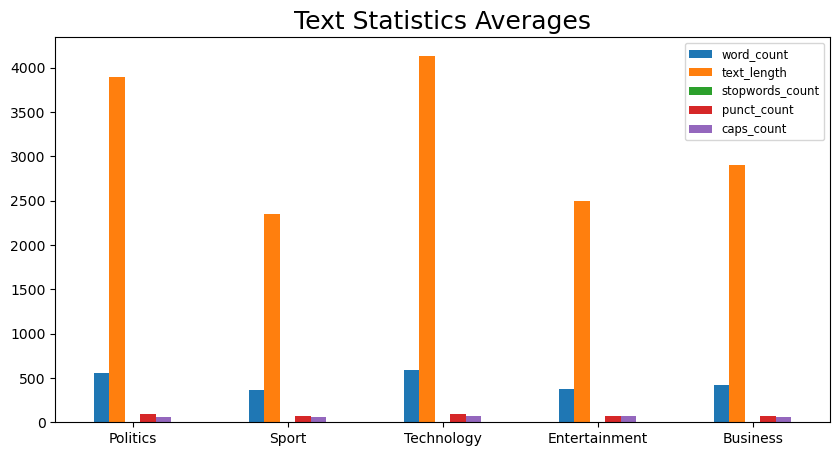

In [235]:
fig, ax=plt.subplots(figsize=(10,5))
grouped_text.plot(kind="bar", ax=ax)
ax.set_xticklabels(["Politics", "Sport", "Technology", "Entertainment", "Business"])
ax.set_title("Text Statistics Averages", fontsize=18)
ax.legend(fontsize="small")
plt.xticks(rotation=0)
plt.show()

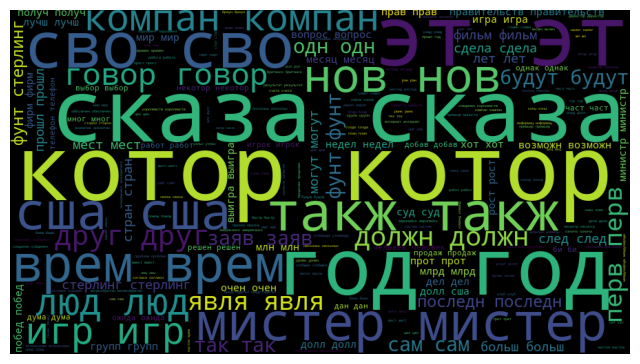

In [236]:
all_cleaned_text = " ".join(df["cleaned_text"])
word_cld = WordCloud(width=900, height=500).generate(all_cleaned_text)
plt.figure(figsize=(8,6))
plt.imshow(word_cld)
plt.axis("off")
plt.show()

## CountVectorizer

In [237]:
count_vec = CountVectorizer(max_features=5000)
count_array = count_vec.fit_transform(df["cleaned_text"]).toarray()
df_count_vec = pd.DataFrame(count_array, columns=count_vec.get_feature_names_out())
df_count_vec = df_count_vec.reset_index(drop=True)
df_count_vec.head()

,аббас,аборт,абсолютн,авар,август,авиакомпан,авиатор,авиац,авив,австр,...,японск,ярд,ярк,ярлык,ярмарк,ясн,ях,ячв,ячейк,ящик
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,0,0,0,0


In [238]:
df1 = df.iloc[:, [1,3,4,5,6,7]]
df1 = df1.reset_index(drop=True)
df1.head()

,Label,word_count,text_length,stopwords_count,punct_count,caps_count
0,0,684,4860,0,86,57
1,0,574,4120,0,83,46
2,0,660,4640,0,109,63
3,0,678,4992,0,81,56
4,0,546,3687,0,96,109


In [239]:
df_nlp = pd.concat([df1, df_count_vec], axis=1)
df_nlp.head()

,Label,word_count,text_length,stopwords_count,punct_count,caps_count,аббас,аборт,абсолютн,авар,...,японск,ярд,ярк,ярлык,ярмарк,ясн,ях,ячв,ячейк,ящик
0,0,684,4860,0,86,57,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,574,4120,0,83,46,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,660,4640,0,109,63,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,678,4992,0,81,56,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,546,3687,0,96,109,0,0,0,0,...,0,0,0,0,0,2,0,0,0,0


## RandomUnderSampler

In [240]:
y = df_nlp["Label"]
X = df_nlp.drop("Label", axis=1)

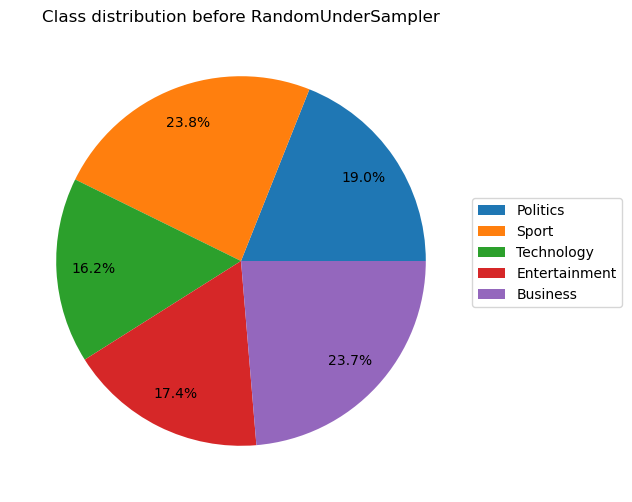

In [241]:
label_counts = y.value_counts().sort_index()

plt.figure(figsize=(6,6))
plt.pie(x=label_counts.values, autopct='%.1f%%', pctdistance=0.8)
plt.legend(labels=["Politics","Sport","Technology", "Entertainment", "Business"], loc=(1,0.4))
plt.title("Class distribution before RandomUnderSampler")
plt.show()

In [242]:
from imblearn.under_sampling import RandomUnderSampler
smote = RandomUnderSampler(sampling_strategy="auto", random_state=42)
X, y = smote.fit_resample(X, y)

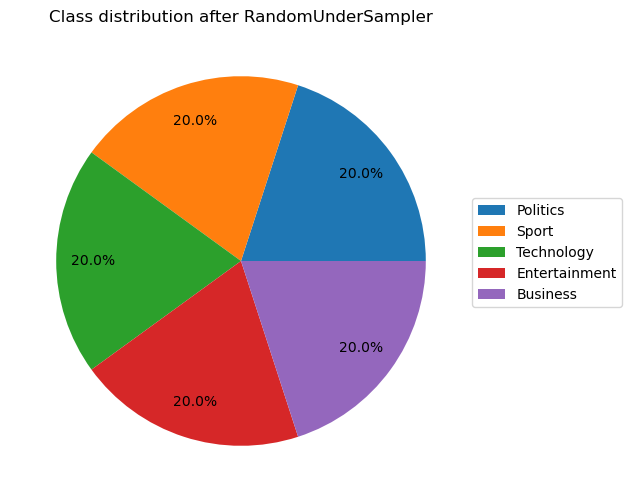

In [243]:
label_counts = y.value_counts().sort_index()

plt.figure(figsize=(6,6))
plt.pie(x=label_counts.values, autopct='%.1f%%', pctdistance=0.8)
plt.legend(labels=["Politics","Sport","Technology", "Entertainment", "Business"], loc=(1,0.4))
plt.title("Class distribution after RandomUnderSampler")
plt.show()

In [244]:
# New shape
print(X.shape)
print(y.shape)

(1725, 5005)
(1725,)


### train/test - split

In [245]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Standardization

In [246]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Models

In [247]:
#######  Logistic Regression  #######
log = LogisticRegression().fit(X_train_scaled, y_train)
y_pred_log = log.predict(X_test_scaled)

#######  RandomForest  #######
rf = RandomForestClassifier().fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)

#######  XGB Classifier  #######
xgb = XGBClassifier().fit(X_train_scaled, y_train)
y_pred_xgb = xgb.predict(X_test_scaled)

#######  LGBM Classifier  #######
lgbm = LGBMClassifier().fit(X_train_scaled, y_train)
y_pred_lgbm = lgbm.predict(X_test_scaled)

#######  CatBoost Classifier  #######
catb = CatBoostClassifier(verbose=False).fit(X_train_scaled, y_train)
y_pred_catb = catb.predict(X_test_scaled)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009890 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11689
[LightGBM] [Info] Number of data points in the train set: 1207, number of used features: 2051
[LightGBM] [Info] Start training from score -1.574432
[LightGBM] [Info] Start training from score -1.644855
[LightGBM] [Info] Start training from score -1.598725
[LightGBM] [Info] Start training from score -1.611096
[LightGBM] [Info] Start training from score -1.619430
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [248]:
# Преобразование данных в формат PyTorch Tensor
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.int64)  # Преобразование Series в массив NumPy
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

# Создание DataLoader для удобства работы с данными в PyTorch
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Определение архитектуры нейронной сети
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# Определение гиперпараметров и создание экземпляра модели
input_size = X_train_tensor.shape[1]
hidden_size = 64
num_classes = len(np.unique(y_train))
learning_rate = 0.001
num_epochs = 50

model = NeuralNetwork(input_size, hidden_size, num_classes)

# Определение функции потерь и оптимизатора
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Обучение модели
for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

# Получение предсказаний на тестовом наборе данных
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs, 1)
y_pred_pytorch = predicted.numpy()

### accuracy

In [249]:
accuracy_log = accuracy_score(y_test, y_pred_log)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
accuracy_lgbm = accuracy_score(y_test, y_pred_lgbm)
accuracy_catb = accuracy_score(y_test, y_pred_catb)
accuracy_pytorch = accuracy_score(y_test, y_pred_pytorch)

## Scores of Models

[0.9594594594594594, 0.9613899613899614, 0.9401544401544402, 0.9478764478764479, 0.9594594594594594, 0.9652509652509652]
LogisticRegression accuracy: 0.9594594594594594


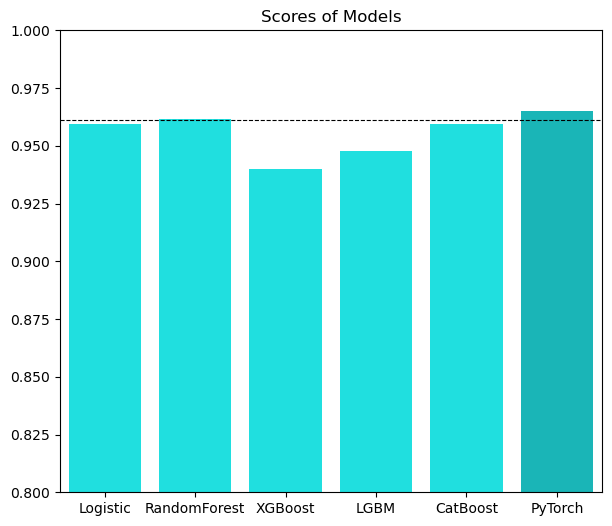

In [250]:
accuracy_list = [accuracy_log, accuracy_rf, accuracy_xgb, accuracy_lgbm, accuracy_catb, accuracy_pytorch]
print(accuracy_list)
fig, ax=plt.subplots(figsize=(7,6))
cols = ["aqua" if i < (max(accuracy_list)) else "darkturquoise" for i in accuracy_list]
sns.barplot(x=np.arange(0,6), y=accuracy_list, ax=ax, palette=cols)
plt.ylim(0.8, 1)
plt.title("Scores of Models")
plt.axhline(0.961, lw=0.8, ls="--", color="k")
ax.set_xticklabels(["Logistic", "RandomForest", "XGBoost", "LGBM", "CatBoost", "PyTorch"])
print(f"LogisticRegression accuracy: {accuracy_log}")
plt.show()

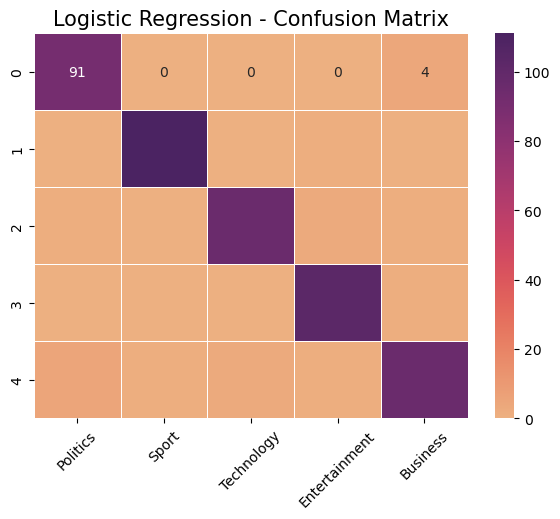

In [251]:
fig, ax=plt.subplots(figsize=(7,5))
sns.heatmap(confusion_matrix(y_test, y_pred_log), annot=True, linewidths=0.4, cmap="flare", fmt='.3g', ax=ax)
ax.set_xticklabels(["Politics", "Sport", "Technology", "Entertainment", "Business"], rotation=45)
ax.set_title("Logistic Regression - Confusion Matrix", fontsize=15)
plt.show()

In [252]:
print(f"############  LOGISTIC REGRESSION CLASSIFICATION REPORT  ############\n\n {classification_report(y_test, y_pred_log)}")

############  LOGISTIC REGRESSION CLASSIFICATION REPORT  ############

               precision    recall  f1-score   support

           0       0.94      0.96      0.95        95
           1       0.99      0.99      0.99       112
           2       0.97      0.95      0.96       101
           3       0.95      0.99      0.97       104
           4       0.94      0.91      0.92       106

    accuracy                           0.96       518
   macro avg       0.96      0.96      0.96       518
weighted avg       0.96      0.96      0.96       518



## Features Importance for LGBM

In [253]:
df_feature_importance = pd.DataFrame(lgbm.feature_importances_, columns=["feature_importance"])
df_feature_importance["features"] = df_nlp.columns[1:]
df_feature_importance = df_feature_importance.sort_values(by="feature_importance", ascending=False).reset_index(drop=True)
df_feature_importance.head()

,feature_importance,features
0,386,text_length
1,385,caps_count
2,279,word_count
3,272,punct_count
4,253,год


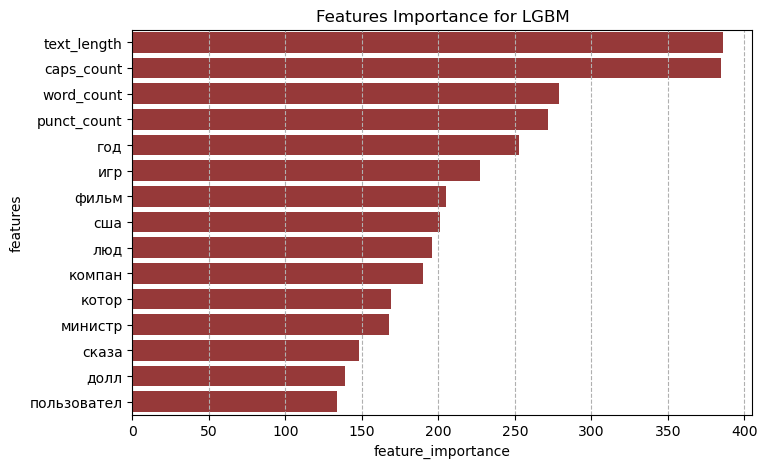

In [254]:
plt.figure(figsize=(8,5))
sns.barplot(x=df_feature_importance.feature_importance[:15], y=df_feature_importance.features[:15], color="brown")
plt.title("Features Importance for LGBM")
plt.grid(axis="x", ls="--")
plt.show()

**_The ranking results above explain the importance of word statistics._**